# We are going to predict the financial loss category (by 6 categories) of a cybersecurity attack, using different models. Our goal is to compare these different models, and see which one is the best in our case.

## Feature Definitions

Here is a short explanation of each variable in the dataset:

- **Country** – Country where the cyber attack occurred.  
- **Year** – Year in which the incident took place.  
- **Attack Type** – Category of attack such as Ransomware, Phishing, Malware, etc.  
- **Target Industry** – Business sector targeted by the attack.  
- **Financial Loss (in Million $)** – Target variable representing the estimated financial impact of the incident.  
- **Number of Affected Users** – Number of users or accounts impacted by the attack.  
- **Attack Source** – Origin of the attack, such as Internal or External.  
- **Security Vulnerability Type** – Type of vulnerability exploited during the attack (e.g., Zero-Day, Misconfiguration).  
- **Defense Mechanism Used** – Security method or technology used at the time of the incident (e.g., Firewall, Encryption).  
- **Incident Resolution Time (in Hours)** – Time required to contain and resolve the cyber attack.


In [3]:
#Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    BaggingRegressor,
    VotingRegressor,
    StackingRegressor
)
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor

In [4]:
# csv opening
df = pd.read_csv("Global_Cybersecurity_Threats_2015-2024.csv")

df.head(5)

,Country,Year,Attack Type,Target Industry,Financial Loss (in Million $),Number of Affected Users,Attack Source,Security Vulnerability Type,Defense Mechanism Used,Incident Resolution Time (in Hours)
0,China,2018.884712,Phishing,Education,388.0,382.0,Hacker Group,Unpatched Software,VPN,458.0
1,China,2018.939848,Ransomware,Retail,270.0,309.0,Hacker Group,Unpatched Software,Firewall,344.0
2,India,2016.727395,Man-in-the-Middle,IT,215.0,257.0,Hacker Group,Weak Passwords,VPN,359.0
3,UK,2024.098701,Ransomware,Telecommunications,372.0,381.0,Nation-state,Social Engineering,Unknown,306.0
4,Germany,2018.082098,Man-in-the-Middle,IT,280.0,273.0,Insider,Social Engineering,VPN,438.0


## Dataset Analysis

Before cleaning or building any models, it is important to understand the structure of the dataset.  
In this section, we explore the main characteristics of the data by looking at general information, descriptive statistics, missing values, and the distribution of both numerical and categorical features.  

We also visualize correlations between numerical variables and take a closer look at the target variable (Financial Loss).  
This initial analysis helps us better understand the dataset and identify potential issues that need to be addressed later.


General informations
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3090 entries, 0 to 3089
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country                              3079 non-null   object 
 1   Year                                 2990 non-null   float64
 2   Attack Type                          3070 non-null   object 
 3   Target Industry                      3076 non-null   object 
 4   Financial Loss (in Million $)        2990 non-null   float64
 5   Number of Affected Users             2990 non-null   float64
 6   Attack Source                        3076 non-null   object 
 7   Security Vulnerability Type          3071 non-null   object 
 8   Defense Mechanism Used               3078 non-null   object 
 9   Incident Resolution Time (in Hours)  2990 non-null   float64
dtypes: float64(4), object(6)
memory usage: 241.5+ KB
None 

Descriptive statist

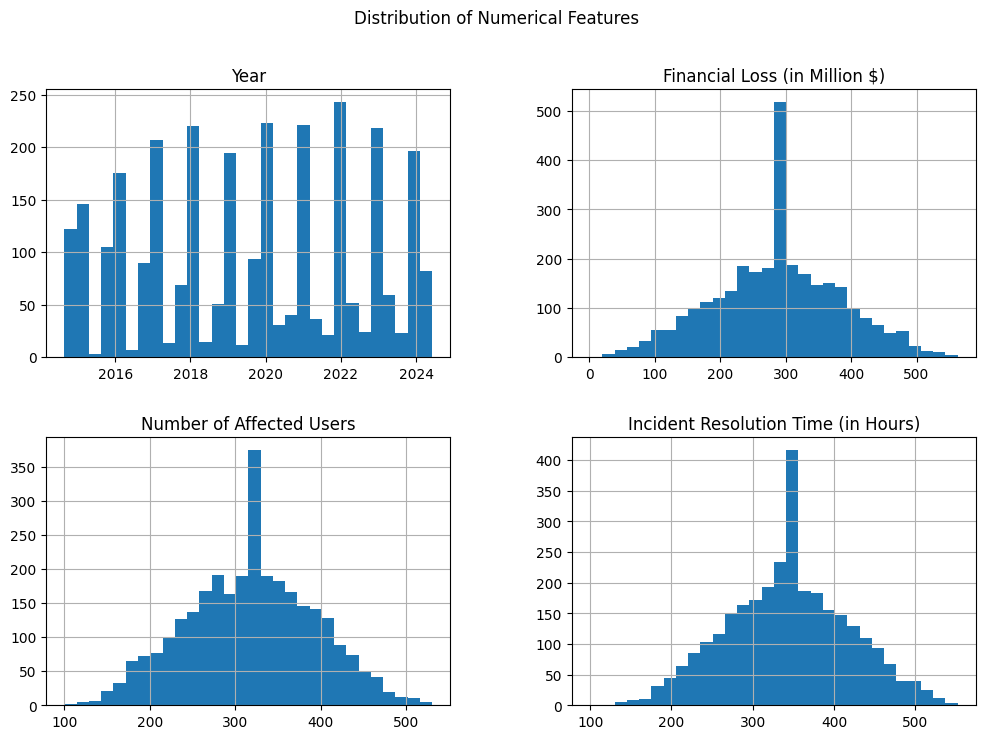

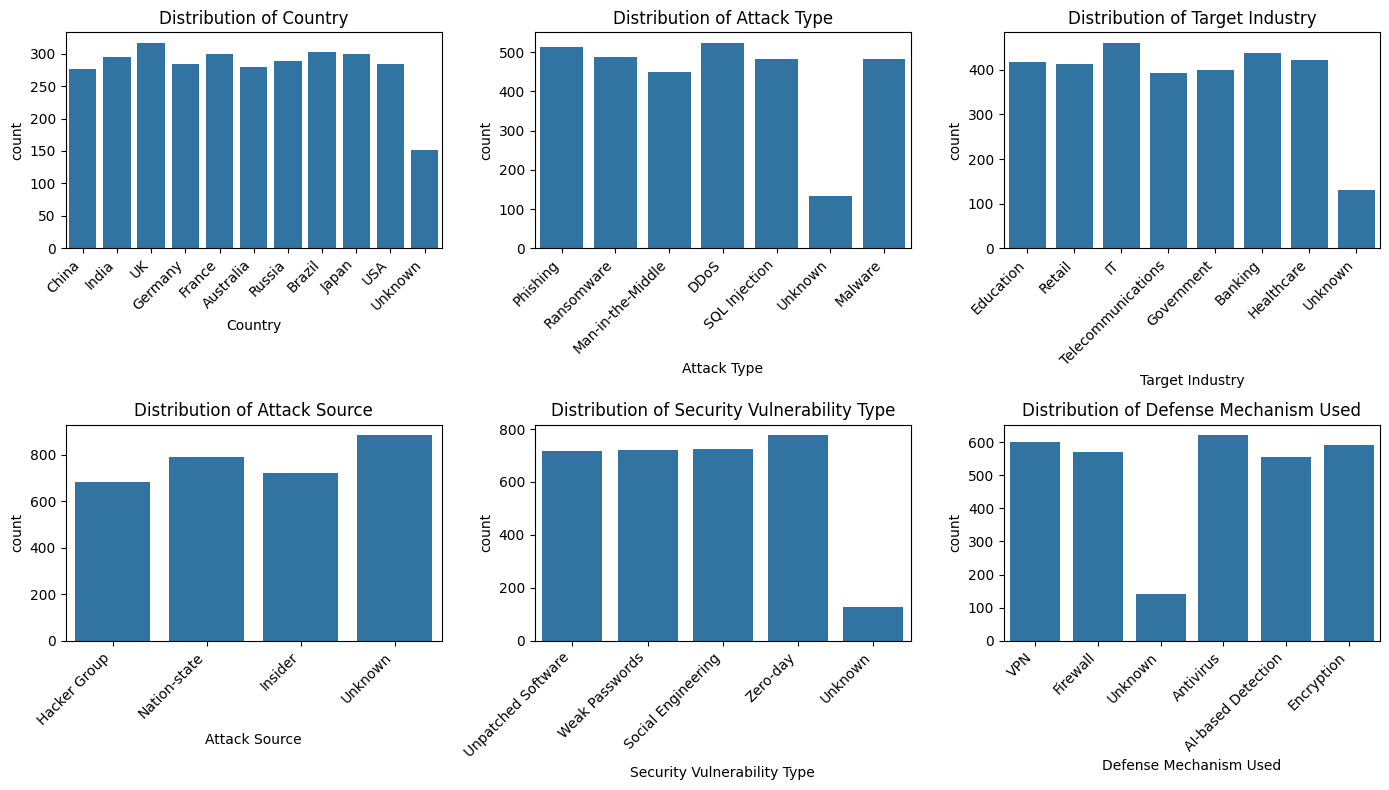

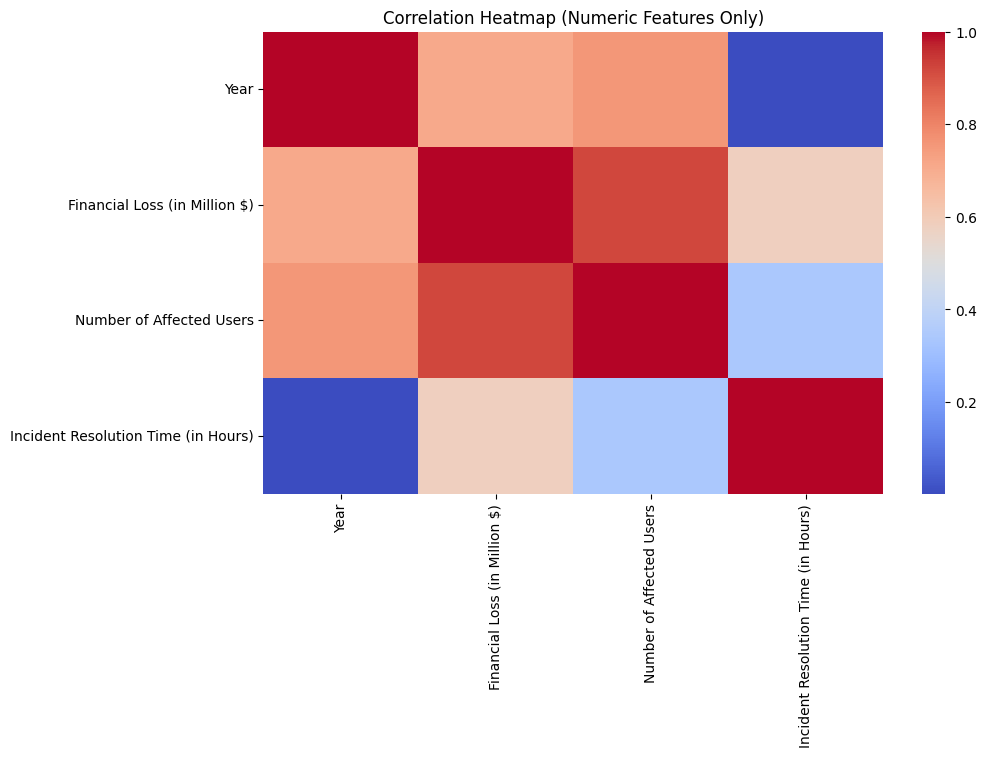

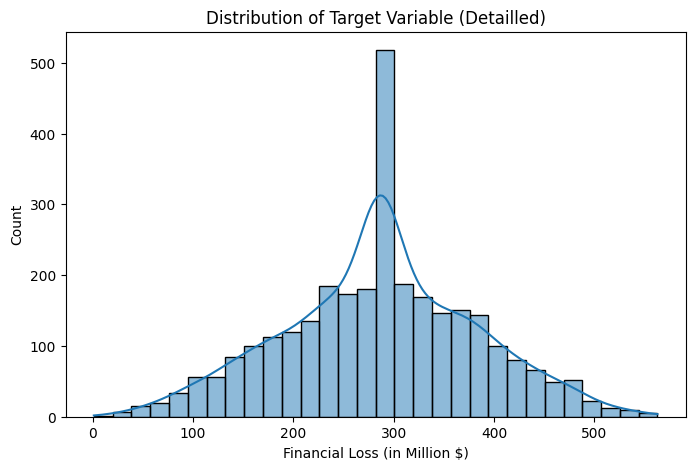

count    2990.000000
mean      286.405351
std        96.456649
min         1.000000
25%       227.000000
50%       287.000000
75%       349.750000
max       563.000000
Name: Financial Loss (in Million $), dtype: float64


In [6]:
print("General informations")
print(df.info(), "\n")

print("Descriptive statistics")
print(df.describe(include='all'), "\n")

print("NaN count")
print(df.isna().sum())

print(f"Number of rows     : {df.shape[0]}")
print(f"Number of columns  : {df.shape[1]}")

# Numerical columns distribution
numeric_cols = df.select_dtypes(include=['int64','float64']).columns

df[numeric_cols].hist(figsize=(12, 8), bins=30)
plt.suptitle("Distribution of Numerical Features")
plt.show()

#Categorical columns distribution
categorical_cols = df.select_dtypes(include=['object']).columns

plt.figure(figsize=(14, 8))

for i, col in enumerate(categorical_cols):
    plt.subplot(2, 3, i+1)
    sns.countplot(data=df, x=col)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

# Corelation matrix

corr = df.corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()

#Fincancial Loss distribution detailled
plt.figure(figsize=(8, 5))
sns.histplot(df["Financial Loss (in Million $)"], kde=True, bins=30)
plt.title("Distribution of Target Variable (Detailled)")
plt.show()

print(df["Financial Loss (in Million $)"].describe())

## Target Variable Balance Discussion

The target variable (Financial Loss) is well distributed. Most values are grouped around 300 million dollars, and the shape looks similar to a normal (bell-shaped) curve.  

There are some smaller and larger losses, but they do not dominate the dataset.  
Overall, the target seems balanced and does not show strong skew or extreme outliers.

This means we can train regression models normally, without needing special transformations.


## Data Cleaning

Before building our models, we need to clean the dataset to make sure it is usable.  
This includes handling missing values, removing outliers, and preparing the features for machine learning.  
The goal is to make the data as consistent and reliable as possible so that the models can learn correctly.


In [9]:
# Cleaning
target = "Financial Loss (in Million $)"

num_cols = df.select_dtypes(include=["number"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

# NaN cleaning
# Fill median for NaN values of numerical columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
# Fill unknown for NaN values of qualitive columns
df[cat_cols] = df[cat_cols].fillna("Unknown")

# Outliers cleaning (IQR method)
Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df = df[(df[target] >= lower) & (df[target] <= upper)]

# Preparation of X & y
X = df.drop(columns=[target])
y = df[target]

# Pipeline
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

# ColumnTransformer: numeric are scalind, categorical are one-hoted
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## Double-Check Before Cleaning

Before applying the full cleaning process, we verify the state of the dataset one more time.  
We check how many missing values remain in each column and look for potential outliers in all numerical features.  
This helps confirm whether additional cleaning steps are needed and gives a clearer view of the data quality.


In [11]:
# Double check
print("NaN count")
print(df.isna().sum())

# Select numeric columns
num_cols = df.select_dtypes(include=['number']).columns

print("Outlier count per column:")

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Count outliers
    outliers = df[(df[col] < lower) | (df[col] > upper)]

    print(f"{col}: {len(outliers)} outliers")


NaN count
Country                                0
Year                                   0
Attack Type                            0
Target Industry                        0
Financial Loss (in Million $)          0
Number of Affected Users               0
Attack Source                          0
Security Vulnerability Type            0
Defense Mechanism Used                 0
Incident Resolution Time (in Hours)    0
dtype: int64
Outlier count per column:
Year: 0 outliers
Financial Loss (in Million $): 10 outliers
Number of Affected Users: 3 outliers
Incident Resolution Time (in Hours): 13 outliers


## Linear Regression (Baseline Model)

Now that our data is clean and ready to use, we can begin testing different models to predict the financial loss associated with a cyber attack.  
As a first step, we start with a simple baseline model: **Linear Regression**.  
This model gives us a reference point to compare more advanced models later on.


In [13]:
# Linear Regression (baseline)

reg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),     # scaling + one-hot encoding
    ("regressor", LinearRegression())   # baseline regression model
])

# Train model
reg_model.fit(X_train, y_train)

# Predictions
pred = reg_model.predict(X_test)

print("Linear Regression")

mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)


Linear Regression
MAE : 11.961797056946274
RMSE: 22.488071690660743
R²  : 0.9385019784804076


## Comment on the Linear Regression results

The Linear Regression model performs quite well as a first baseline:

- **MAE = 11.96** : On average, the model is off by about 12 million dollars, which is relatively low compared to the overall scale of the financial losses.
- **RMSE = 22.49** : The errors remain stable without large spikes, meaning the model does not make extreme mistakes.
- **R² = 0.94** : The model explains about 94% of the variation in financial loss, which is a very strong result for a simple linear approach.

Overall, Linear Regression already provides solid performance.  
However, our goal is to **increase R²** and **reduce MAE and RMSE** even further.  
To see if we can improve the predictions, we will now try more advanced models.


In [15]:
# SVR (baseline)

svr_reg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),   # scaling + one-hot encoding
    ("regressor", SVR(kernel="rbf"))  # baseline svr regressor
])

# Train model
svr_reg_model.fit(X_train, y_train)

# Predictions
pred = svr_reg_model.predict(X_test)

print("SVR")

mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)


SVR
MAE : 25.428661125623382
RMSE: 37.9351379784255
R²  : 0.8249991951926099


## Comment on SVR results

The Support Vector Regressor (SVR) does not perform as well as the previous models.  
Its error values are higher, and the R² score is noticeably lower, meaning it struggles to capture the relationship between the features and the financial loss.

SVR often works better when the data is reduced or transformed, especially when there are many features after one-hot encoding.  
To try improving its performance, we will apply **PCA (Principal Component Analysis)** to reduce the dimensionality of the dataset and help the SVR model focus on the most important information.


In [17]:
# Preparation of X & y
X = df.drop(columns=[target])
y = df[target]

# Re-detect columns
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ],
    sparse_threshold=0 
)

svm_pca_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=0.95)),  
    ("regressor", SVR(C=1, gamma=0.1, kernel="rbf"))
])

svm_pca_model.fit(X_train, y_train)
pred_svm_pca = svm_pca_model.predict(X_test)

print("PCA - SVR")

mae = mean_absolute_error(y_test, pred_svm_pca)
mse = mean_squared_error(y_test, pred_svm_pca)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred_svm_pca)

print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)

PCA - SVR
MAE : 21.843213905951053
RMSE: 33.65659727334277
R²  : 0.8622482508616608


## Comment on PCA-SVR results

After applying PCA, the SVR model improves slightly and becomes more accurate than before.  
However, the performance is still below our baseline Linear Regression, which remains the most effective model so far.

Since PCA-SVR does not outperform the simpler approach, we will keep Linear Regression as our best option for now.  
Next, we will test another type of model: the **Decision Tree Regressor**.


In [19]:
# Decision Tree Regressor (baseline)

dt_reg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", DecisionTreeRegressor(
        criterion="squared_error",   
        max_depth=6,
        random_state=42
    ))
])

# Train model
dt_reg_model.fit(X_train, y_train)

# Predictions
pred = dt_reg_model.predict(X_test)

print("Decision Tree Regressor")

mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)


Decision Tree Regressor
MAE : 16.981064507824783
RMSE: 23.330017322851678
R²  : 0.9338108456550351


## Comment on Decision Tree Regressor results

The Decision Tree Regressor gives results that are still quite competitive.  
It manages to capture patterns in the data fairly well, and its performance is close to the models tested earlier.  

However, decision trees can sometimes overfit and may not generalize as well as simpler or ensemble models.  
To see if we can get even better performance, we will now try more advanced tree-based models.


## Random Forest Regressor

Now that we have explored the baseline model, we can move on to more advanced methods.  
Random Forest is an ensemble model that combines multiple decision trees to improve accuracy and reduce overfitting.  
Let's see how well this model performs on our dataset compared to the previous ones.


In [22]:
# RandomForest Regressor (advanced model)

rf_reg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

# Train model
rf_reg_model.fit(X_train, y_train)

# Predictions
pred = rf_reg_model.predict(X_test)

print("Random Forest Regressor")

mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)


Random Forest Regressor
MAE : 7.632124183006537
RMSE: 11.593408741725762
R²  : 0.983655222780818


## Comment on Random Forest results

The results from the Random Forest model are excellent.  
The errors are very low, and the model achieves a level of accuracy that is almost perfect compared to our previous approaches.  
This shows that ensemble methods can capture complex patterns much better than single models like Linear Regression or Decision Trees.

Since Random Forest performs extremely well, we can now move on and explore other strong models such as **Gradient Boosting** or a **MLP Neural Network** to see if we can push the performance even further.


In [24]:
# Gradient Boosting Regressor (advanced model)

gb_reg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3
    ))
])

# Train model
gb_reg_model.fit(X_train, y_train)

# Predictions
pred = gb_reg_model.predict(X_test)

print("Gradient Boosting Regressor")

mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)


Gradient Boosting Regressor
MAE : 7.972934568168273
RMSE: 11.954495258010498
R²  : 0.9826212234973831


## Comment on Gradient Boosting results

The Gradient Boosting Regressor delivers results similar to the Random Forest model.  
Its predictions are very accurate, and the error values remain extremely low, showing that this advanced ensemble method also captures the underlying patterns of the data very effectively.

Since the performance is nearly identical to Random Forest, we can confirm that tree-based ensemble models work exceptionally well on this dataset.


In [26]:
# MLP Neural Network Regressor

mlp_reg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", MLPRegressor(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        max_iter=2000,
        learning_rate_init=0.001,
        random_state=42
    ))
])

# Train model
mlp_reg_model.fit(X_train, y_train)

# Predictions
pred = mlp_reg_model.predict(X_test)

print("MLP Neural Network Regressor")

mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)


MLP Neural Network Regressor
MAE : 19.416362249367367
RMSE: 28.63005971261561
R²  : 0.9003215634397991


## Comment on MLP Neural Network Results

The results from the MLP Neural Network are a bit less good compared to the tree-based models.  
Although the model still performs reasonably well, it does not reach the high accuracy of Random Forest or Gradient Boosting.
It is maybe because MLP is often used in very large amount of data.

This suggests that neural networks may not be the best fit for this dataset, especially when simpler ensemble models already provide excellent predictions.


## Model Ranking and Next Steps

Now that we have tested several different models, we can rank them based on their overall performance:

1. Random Forest Regressor  
2. Gradient Boosting Regressor  
3. Linear Regression  
4. Decision Tree Regressor  
5. MLP Neural Network Regressor  
6. SVR  

This ranking shows that ensemble tree-based models perform the best on our dataset, while SVR and MLP are less effective.

However, many models can still be improved by tuning their hyperparameters.  
To continue optimizing our results, we will now perform hyperparameter tuning, especially on the baseline models such as **Linear Regression**, **SVR**, and **Decision Tree**, to see if we can boost their performance even further.


## Grid Search for Hyperparameter Tuning

Before improving our baseline models, we need a method to automatically find the best hyperparameters.  
For this, we use **Grid Search**, a technique that tests different parameter combinations and selects the one that gives the best performance.

Since we are using **Ridge Regression** (a regularized version of Linear Regression), Grid Search will help us find the optimal value for its key hyperparameter.  
This will show whether a tuned version of Linear Regression can perform even better than our initial baseline model.


In [30]:
# Pipeline with preprocessing and Ridge Regression
best_linreg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", Ridge())
])

# Search space 
param_grid = {
    "regressor__alpha": [0.01, 0.1, 1, 10, 100],
    "regressor__solver": ["auto", "lsqr", "sparse_cg", "sag"]
}

grid_search = GridSearchCV(
    best_linreg_model,
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Grid Search best result (Ridge Regression)")
print("Best R²:", grid_search.best_score_)
print("Best Params:", grid_search.best_params_)


Grid Search best result (Ridge Regression)
Best R²: 0.9406185879185929
Best Params: {'regressor__alpha': 10, 'regressor__solver': 'lsqr'}


Now that we have the best parameters, let's apply them

In [32]:
# Applying parameters on Ridge Regression
best_linreg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", Ridge(
        alpha=10,
        solver="lsqr",
    ))
])

best_linreg_model.fit(X_train, y_train)
pred_best = best_linreg_model.predict(X_test)

print("Linear regressor (tuned with Ridge)")

mae = mean_absolute_error(y_test, pred_best)
mse = mean_squared_error(y_test, pred_best)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred_best)

print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)


Linear regressor (tuned with Ridge)
MAE : 12.03522766900135
RMSE: 22.49205523536531
R²  : 0.9384801889895819


## Comment on Tuned Ridge Regression results

We can see that choosing new hyperparameters has slightly improved the reliability of the model.  
The tuned Ridge Regression performs a bit better than the original baseline version, showing lower error values and a more stable fit.

Although the improvement is modest, it confirms that hyperparameter tuning can help refine even simple models like Linear Regression.


In [34]:
# Pipeline with preprocessing and SVR
svr_reg_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", SVR())
])

# Search space
svr_reg_param_grid = {
    "regressor__C": [0.1, 1, 10, 50],
    "regressor__gamma": ["scale", 0.1, 0.01],
    "regressor__kernel": ["rbf"] 
}

svr_reg_grid_search = GridSearchCV(
    svr_reg_pipe,
    svr_reg_param_grid,
    cv=5,
    scoring="r2",      
    n_jobs=-1
)

svr_reg_grid_search.fit(X_train, y_train)

print("Grid Search best results (SVR)")
print("Best R²:", svr_reg_grid_search.best_score_)
print("Best Params:", svr_reg_grid_search.best_params_)


Grid Search best results (SVR)
Best R²: 0.9399849899230237
Best Params: {'regressor__C': 50, 'regressor__gamma': 0.1, 'regressor__kernel': 'rbf'}


In [35]:
# Applying parameters on SVR
best_svr_reg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", SVR(
        C=50,
        gamma=0.1,
        kernel="rbf"
    ))
])

best_svr_reg_model.fit(X_train, y_train)
pred_best_svr = best_svr_reg_model.predict(X_test)

print("SVR (Tuned)")

mae = mean_absolute_error(y_test, pred_best_svr)
mse = mean_squared_error(y_test, pred_best_svr)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred_best_svr)

print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)


SVR (Tuned)
MAE : 11.512682916677626
RMSE: 23.3078961315362
R²  : 0.9339363053807849


## Comment on Tuned SVR results

The tuned SVR model performs much better than the original version.  
By adjusting the hyperparameters, the model is now able to capture the relationships in the data more effectively, resulting in noticeably lower errors and a higher R² score.

This shows that SVR can become a competitive model when properly optimized, even if its untuned version initially performed poorly.


In [77]:
# Pipeline: preprocessing + Decision Tree Regressor
dt_reg_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", DecisionTreeRegressor(random_state=42))
])

# Search space
dt_reg_param_grid = {
    "regressor__criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
    "regressor__max_depth": [3, 5, 7, 10, None],
    "regressor__min_samples_split": [2, 5, 10],
    "regressor__min_samples_leaf": [1, 2, 4]
}

dt_reg_grid_search = GridSearchCV(
    dt_reg_pipe,
    dt_reg_param_grid,
    cv=5,
    scoring="r2",   
    n_jobs=-1
)

dt_reg_grid_search.fit(X_train, y_train)

print("Grid Search best results (Decision Tree Regressor)")
print("Best R²:", dt_reg_grid_search.best_score_)
print("Best Params:", dt_reg_grid_search.best_params_)


Grid Search best results (Decision Tree Regressor)
Best R²: 0.9678116864977954
Best Params: {'regressor__criterion': 'squared_error', 'regressor__max_depth': None, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 2}


In [38]:
# Applying parameters on Decision Tree Regressor
best_dt_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", DecisionTreeRegressor(
        criterion="friedman_mse",  
        max_depth=10,                 
        min_samples_split=5,         
        min_samples_leaf=2,         
    ))
])

best_dt_model.fit(X_train, y_train)
pred_best_dt = best_dt_model.predict(X_test)

print("Decision Tree Regressor (tuned)")

mae = mean_absolute_error(y_test, pred_best_dt)
mse = mean_squared_error(y_test, pred_best_dt)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred_best_dt)

print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)


Decision Tree Regressor (tuned)
MAE : 11.327537284538971
RMSE: 17.616750192230874
R²  : 0.9622594433054203


## Updated Model Ranking After Hyperparameter Tuning

After applying hyperparameter tuning to some of our models, we can now establish a new and more accurate ranking based on their improved performances:

1. Random Forest Regressor  
2. Gradient Boosting Regressor  
3. SVR (Tuned)  
4. Linear Regression (Tuned)  
5. Decision Tree (Tuned)  
6. Linear Regression  
7. Decision Tree  
8. MLP Neural Network Regressor  
9. SVR (Original)  

This updated ranking shows that tuning can significantly change the order of the models, especially for SVR, which becomes one of the top performers after optimization.  
However, the ensemble models (Random Forest and Gradient Boosting) still remain the strongest overall.


## Ensemble Models

We can now explore another family of models: **ensemble methods**.  
These models combine several individual learners to create a stronger and more stable predictor.  
The idea is that multiple models working together can often achieve better performance than a single model alone.

In this section, we will analyse three different ensemble techniques:

- **Voting Ensemble**  
- **Bagging Ensemble**  
- **Stacking Ensemble**

Let's see how well these ensemble approaches perform compared to the models we have tested so far.


In [41]:
# Voting Regressor
voting_reg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", VotingRegressor(
        estimators=[
            ("lr", LinearRegression()),
            ("svr", SVR(kernel="rbf")),
            ("rf", RandomForestRegressor(n_estimators=300, random_state=42))
        ]
    ))
])

voting_reg_model.fit(X_train, y_train)
pred_voting = voting_reg_model.predict(X_test)

print("Voting Regressor")

mae = mean_absolute_error(y_test, pred_voting)
mse = mean_squared_error(y_test, pred_voting)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred_voting)

print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)


Voting Regressor
MAE : 13.948816843502803
RMSE: 20.6186664493421
R²  : 0.9483015102951698


In [42]:
# Bagging Regressor
bagging_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", BaggingRegressor(
        estimator=DecisionTreeRegressor(max_depth=6),
        n_estimators=50,
        random_state=42,
        n_jobs=-1
    ))
])

bagging_model.fit(X_train, y_train)
pred_bagging = bagging_model.predict(X_test)

print("Bagging Regressor")

mae = mean_absolute_error(y_test, pred_bagging)
mse = mean_squared_error(y_test, pred_bagging)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred_bagging)

print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)


Bagging Regressor
MAE : 12.126053803265812
RMSE: 16.214794009597046
R²  : 0.9680272802067501


In [43]:
# Stacking Regressor
stacking_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", StackingRegressor(
        estimators=[
            ("lr", LinearRegression()),
            ("svr", SVR(kernel="rbf")),
            ("rf", RandomForestRegressor(n_estimators=300, random_state=42))
        ],
        final_estimator=GradientBoostingRegressor(),
        n_jobs=-1
    ))
])

stacking_model.fit(X_train, y_train)
pred_stacking = stacking_model.predict(X_test)

print("Stacking Regressor")

mae = mean_absolute_error(y_test, pred_stacking)
mse = mean_squared_error(y_test, pred_stacking)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred_stacking)

print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)


Stacking Regressor
MAE : 6.9314148982541965
RMSE: 10.792635714304556
R²  : 0.9858351575992248


## Comment on Ensemble Models

All three ensemble methods (Voting, Bagging, and Stacking) provide solid results and help improve stability compared to individual models.  
However, among the three, the **Stacking Regressor clearly performs the best**, offering the most accurate and reliable predictions.

This confirms that combining different models in a stacked structure can capture more information from the dataset than simpler ensemble techniques.


## Comparing predictions with true values

To better understand how well our model performs, we can compare its predictions directly with the real financial loss values.  
This helps us see if the model stays close to the actual outcomes or if it makes noticeable errors.  
By visualizing both sets of values, we can quickly evaluate how accurate and reliable the model is.


In [46]:
def plot_prediction_comparison(y_true, y_pred, title):
    plt.figure(figsize=(10, 5))

    plt.hist(y_true, bins=20, alpha=0.6, label="True Values", color="skyblue", edgecolor="black")
    plt.hist(y_pred, bins=20, alpha=0.6, label="Predicted Values", color="orange", edgecolor="black")

    plt.xlabel("Financial Loss")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


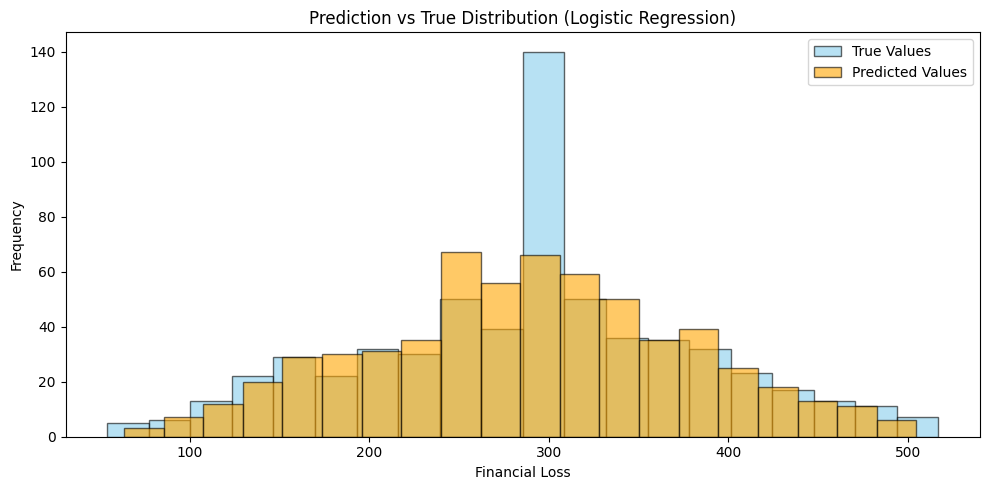

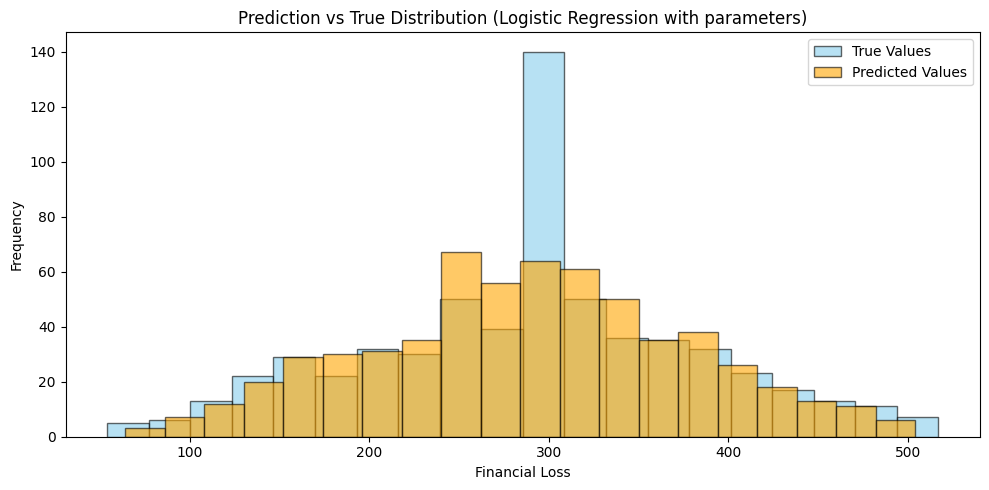

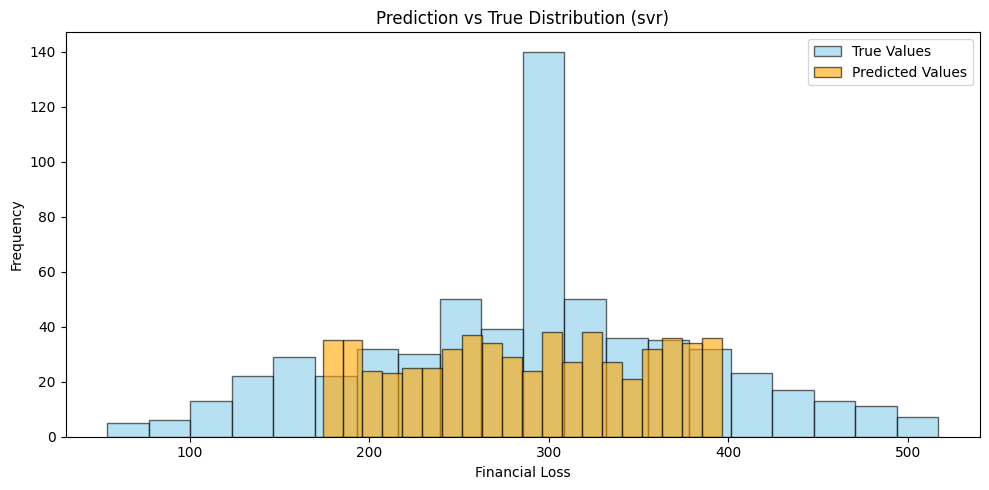

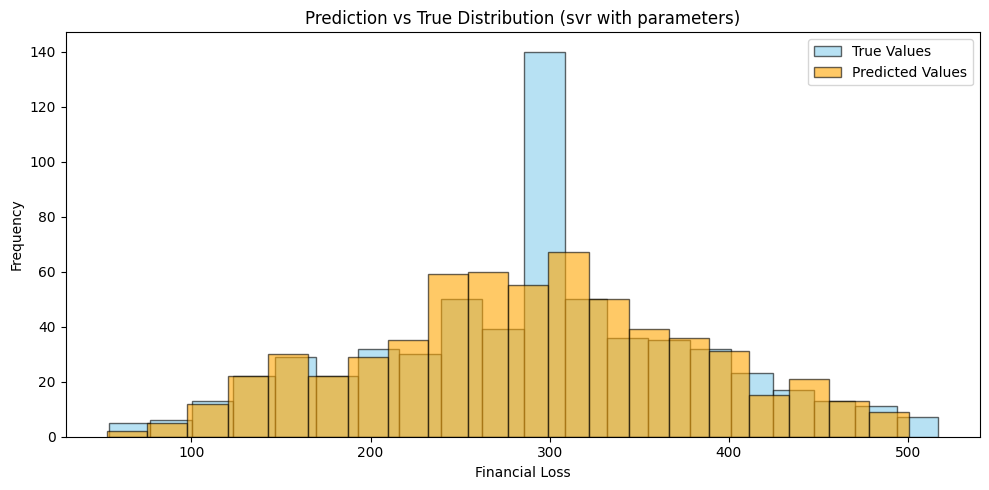

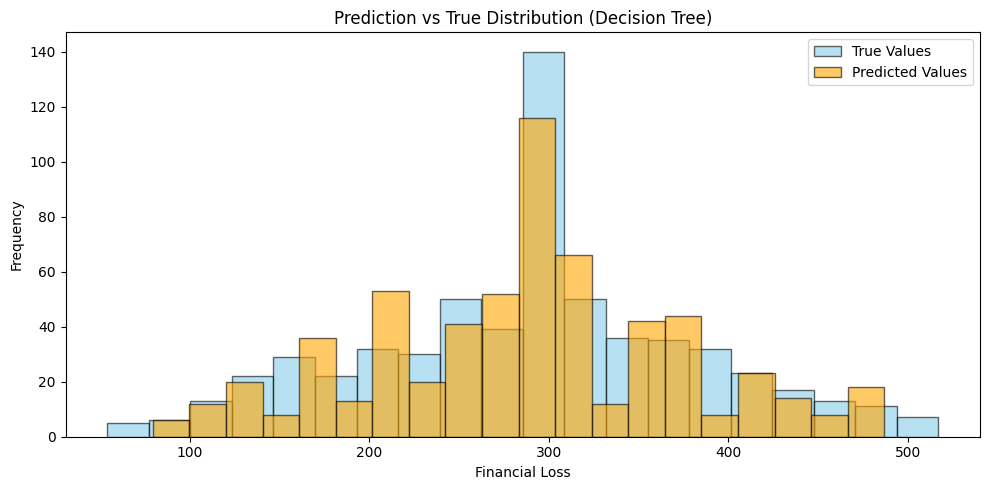

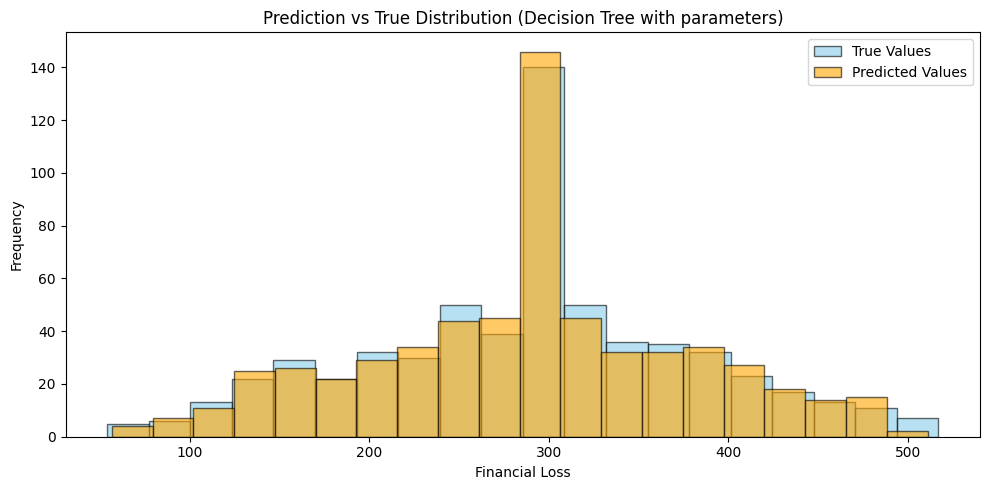

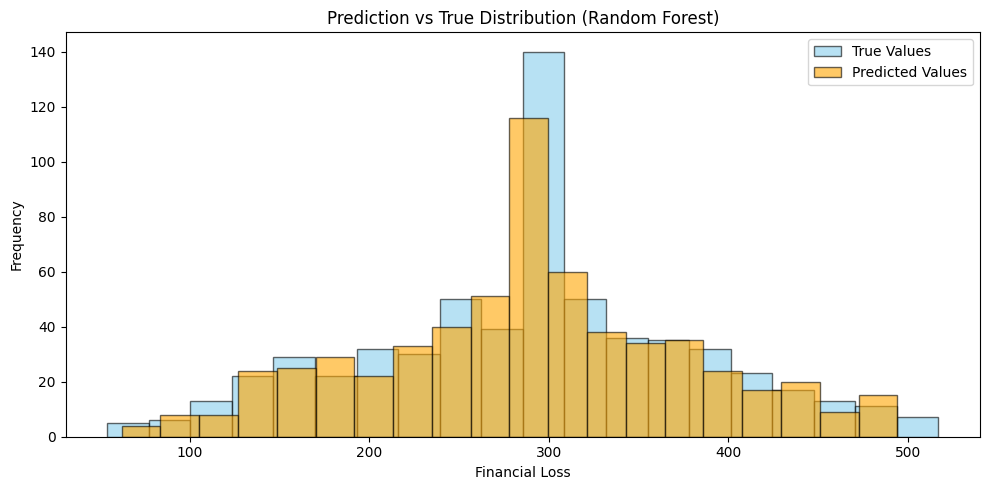

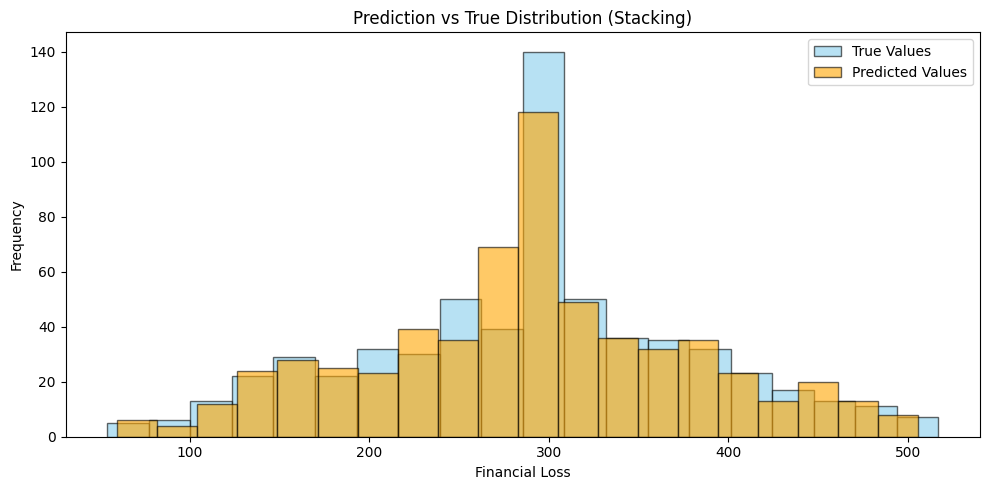

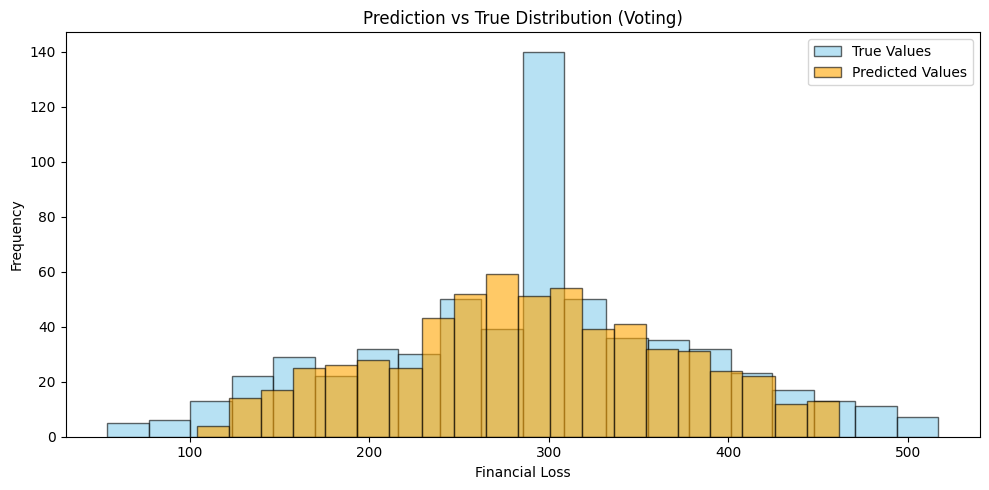

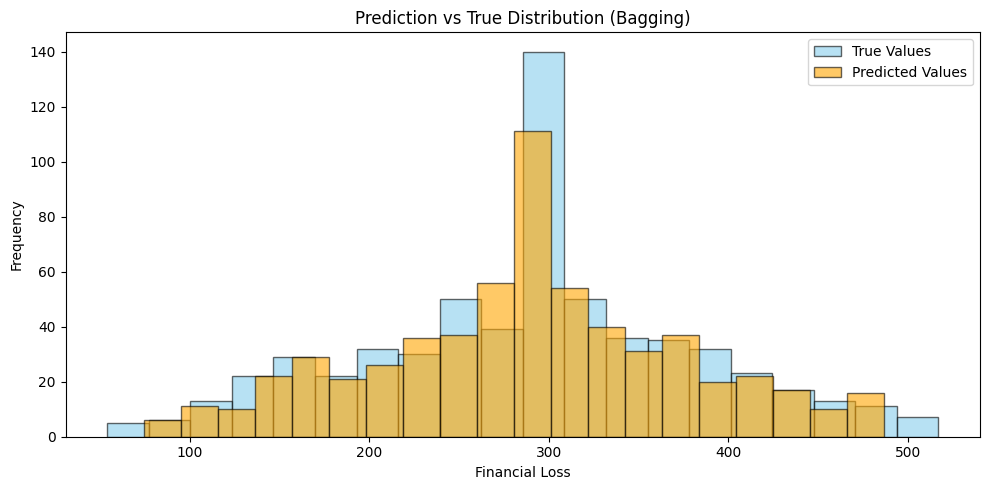

In [47]:
pred = reg_model.predict(X_test)
plot_prediction_comparison(y_test, pred, "Prediction vs True Distribution (Logistic Regression)")

pred = best_linreg_model.predict(X_test)
plot_prediction_comparison(y_test, pred, "Prediction vs True Distribution (Logistic Regression with parameters)")

pred = svr_reg_model.predict(X_test)
plot_prediction_comparison(y_test, pred, "Prediction vs True Distribution (svr)")

pred = best_svr_reg_model.predict(X_test)
plot_prediction_comparison(y_test, pred, "Prediction vs True Distribution (svr with parameters)")

pred = dt_reg_model.predict(X_test)
plot_prediction_comparison(y_test, pred, "Prediction vs True Distribution (Decision Tree)")

pred = best_dt_model.predict(X_test)
plot_prediction_comparison(y_test, pred, "Prediction vs True Distribution (Decision Tree with parameters)")

pred = rf_reg_model.predict(X_test)
plot_prediction_comparison(y_test, pred, "Prediction vs True Distribution (Random Forest)")

pred = stacking_model.predict(X_test)
plot_prediction_comparison(y_test, pred, "Prediction vs True Distribution (Stacking)")

pred = voting_reg_model.predict(X_test)
plot_prediction_comparison(y_test, pred, "Prediction vs True Distribution (Voting)")

pred = bagging_model.predict(X_test)
plot_prediction_comparison(y_test, pred, "Prediction vs True Distribution (Bagging)")

## Example: Predicting the Financial Impact of a Future Attack

With all the models we have trained and analyzed, we can now try to estimate the financial impact of a new cyber attack scenario.  
Below is a fictional example describing the characteristics of an incoming attack:

- **Country:** USA  
- **Year:** 2030  
- **Attack Type:** Ransomware  
- **Target Industry:** Banking  
- **Number of Affected Users (k):** 500  
- **Attack Source:** External  
- **Security Vulnerability Type:** Zero-Day  
- **Defense Mechanism Used:** Firewall  
- **Incident Resolution Time:** 120h  

Using this information, we will predict the expected financial loss category for this hypothetical attack.


In [49]:
# New attack scenario
new_attack = pd.DataFrame([{
    "Country": "USA",
    "Year": 2030,
    "Attack Type": "Ransomware",
    "Target Industry": "Banking",
    "Number of Affected Users": 500,
    "Attack Source": "External",
    "Security Vulnerability Type": "Zero-Day",
    "Defense Mechanism Used": "Firewall",
    "Incident Resolution Time (in Hours)": 120
}])


In [50]:
# Apply different models to see the difference between obtained result
prediction = stacking_model.predict(new_attack)[0]
print("Predicted Loss Category: (Stacking model)", prediction)

prediction = rf_reg_model.predict(new_attack)[0]
print("Predicted Loss Category: (Random Forest model):", prediction)

prediction = best_svr_reg_model.predict(new_attack)[0]
print("Predicted Loss Category: (Hyperparametered SVR model)", prediction)

Predicted Loss Category: (Stacking model) 396.6727513008313
Predicted Loss Category: (Random Forest model): 445.2133333333333
Predicted Loss Category: (Hyperparametered SVR model) 330.04706595452853


## Final conclusion

Throughout this project, we explored a wide range of machine learning models to predict the financial loss caused by cyber attacks.  
We cleaned and analyzed the dataset, handled missing values and outliers, and tested many different approaches—from simple baseline models to more advanced tree-based and ensemble methods.

Our results show that **ensemble models**, especially **Random Forest**, **Gradient Boosting**, and the **Stacking Regressor**, provide the highest accuracy.  
These models capture complex relationships in the data better than simpler approaches like Linear Regression, Decision Trees, MLP, or standard SVR.

Even after hyperparameter tuning, the ensemble models remained the top performers, confirming their effectiveness on this type of dataset.

Finally, we used our best model to make a prediction on a new fictional cyber attack scenario, demonstrating how machine learning can help estimate the potential financial impact of real-world security incidents.

Overall, this project highlights the importance of data preparation, model comparison, and tuning to achieve strong and reliable predictions.
